In [13]:
import torch
from torch.optim.optimizer import Optimizer

In [14]:
def closure(size_params,mu):
    grad_est = []
    
    u = torch.normal(mean = torch.zeros(size_params),std = 1)
    u = torch.div(u,torch.norm(u,"fro"))
    
    # initial evaluation
    output = model(input)
    loss_init = criterion.forward(output)
    
    # save the state of the model 
    model_init = dict(model.state_dict())
    
    start_ind = 0
    for param_tensor in model.state_dict():
        end_ind = start + model.state_dict()[param_tensor].view(-1).size()[0]
        model.state_dict()[param_tensor].add_(u[start_ind:end_ind].view(model.state_dict()[param_tensor].size()), value = mu)
    
    # random evaluation
    output2 = model(input)
    loss_random = criterion.forward(output2)
    
    
    # load initial state
    model.load_state_dict(model_init)
    
    # compute the gradient
    
    grad_norm = size_params*(loss_random-loss_init)/mu
    grad_est = []
    
    start_ind = 0
    for param_tensor in model_init:
        end_ind = start + model_init[param_tensor].view(-1).size()[0]
        grad_est.apppend(grad_norm*u[start_ind:end_ind].view(model_init[param_tensor].size()))
    
    return grad_est
     

In [15]:
class ZO_AdaMM(Optimizer):
    
    def __init__(self,params,lr = 1e-03,betas = (0.9,0.999), mu = 1e-05, eps = 1e-12):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: (} - should be >= 0.0". format (lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError ("Invalid beta parameter: (} - should be in [0.0, 1.0[". format (betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0l". format (betas [1]))
        if not 0.0 <= mu < 1.0:
            raise ValueError("Invalid mu parameter: {} - should be in [0.0, 1.0l". format (mu))
            
        defaults = dict(lr=lr, betas=betas, mu=mu, eps = eps)
        super(ZO_AdaMM,self).__init__(params,defaults)
        
    def step(self, closure):
        
         for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']
            
            size_params = 0
            
            for p in group['params']:
                size_params += p.view(-1).size()[0]
            
            # closure return the approximation for the gradient, we have to add some "option" to this function 
            grad_est = closure(size_params,group["mu"])
            
            i = 0
            for p in group['params']:    
                #grads.append(grad_est[i])
                state = self.state[p]
                # Lazy state initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    #if group['amsgrad']:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])

                #if group['amsgrad']:
                max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                # update the steps for each param group update
                state['step'] += 1
                # record the step after step update
                state_steps.append(state['step'])
                    
                
                beta1, beta2 = group['betas']
                state['exp_avg'].mul_(beta1).add_(grad_est[i],alpha = (1.0 - beta1))
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad_est[i], grad_est[i],value = (1.0 - beta2))
                state['max_exp_avg_sq'] = torch.maximum(state['max_exp_avg_sq'],state['exp_avg_sq'])# vérifier max ou maximum
                
                p.data.addcdiv_(state['exp_avg'], state['exp_avg_sq'].sqrt().add_(group['eps']),value = (-group['lr']))
                i +=1
           
        

In [16]:
import torch
import torch.nn.functional as F
import torchvision


import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,12)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        #self.fc1 = nn.Linear(9 * 5 * 5, 15)
        #self.fc2 = nn.Linear(15, 13)
        self.fc3 = nn.Linear(9 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [47]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset_train = torchvision.datasets.MNIST('data/mnist/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=10)

mnist_dataset_test = torchvision.datasets.MNIST('data/mnist/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=10)

criterion = nn.CrossEntropyLoss()

nb_epochs = 10

In [57]:
def train(model, optimizer, criterion, nb_epochs, train_loader, test_loader):
    # Heavily inspired from PyTorch tutorial
    train_losses = []
    test_accuracies = []

    global running_loss
    running_loss = 0
    lr_init = optimizer_pt.param_groups[0]['lr']
    mu_init = optimizer_pt.param_groups[0]['mu']
    
    for e in range(nb_epochs):
        ## change the learning rate alon iteration
        #optimizer_pt.param_groups[0]['lr'] = max(lr_init/(np.sqrt(10)**(e/2.)),1e-4)
        #optimizer_pt.param_groups[0]['mu'] = max(mu_init/(np.sqrt(10)**(e/2.)),1e-4)
        for i, data in enumerate(train_loader):
            input, labels = data
            
            #optimizer.zero_grad()
            outputs = model(input)
            batch_size = labels.size(0)
            
            def closure(size_params, mu):
                grad_est = []
                
                global running_loss
                
                ## Generate a random direction uniformly on the unit ball or with a gaussian distribution 
                #u = torch.normal(mean = torch.zeros(size_params),std = 100)
                u = 2*(torch.rand(size_params)-0.5) # need small modif in order to be on the unit sphere
                u.div_(torch.norm(u,"fro"))
                
                ## save the state of the model
                model_init = dict(model.state_dict())
                grad_norm = 0  
                    
                ## we add to the inital parameters a random perturbation times \mu
                start_ind = 0
                for param_tensor in model.state_dict().values(): 
                    end_ind = start_ind + param_tensor.view(-1).size()[0]
                    param_tensor.add_(u[start_ind:end_ind].view(param_tensor.size()), alpha = mu)
                    start_ind = end_ind
                    
                for j in range(batch_size):
                    ## initial evaluation
                    output = outputs[j].view(1,10)
                    loss_init = criterion(output, labels[j].view(1))

                    running_loss = running_loss + loss_init.item()


                    ## evaluation of the model and the loss with a random perturbation of the parameters
                    output2 = model(input)
                    loss_random = criterion(output2,labels)

                    ## compute the "gradient norm"
                    
                    ## when u is uniform random variable
                    grad_norm += size_params*(loss_random-loss_init)/mu
                    
                    ## when u is Gaussian random variable
                    #grad_norm += (loss_random-loss_init)/mu
                    #print(grad_norm,(loss_random-loss_init))
                    
                    ## compute the gradient estimation
                start_ind = 0
                for param_tensor in model_init.values():
                    end_ind = start_ind + param_tensor.view(-1).size()[0]
                    #grad_est[layer_name] = grad_est.get(layer_name, 0) + grad_norm*u[start_ind:end_ind].view(param_tensor.size())
                    grad_est.append((grad_norm/batch_size)*u[start_ind:end_ind].view(param_tensor.size()))
                    start_ind = end_ind
                
                ## reload initial state of the parameters
                model.load_state_dict(model_init) # try to subtract the random vector to get back initial params


                ## we return the average between all the estimated gradient of the batch
                #return [v / batch_size for v in grad_est.values()]
                return grad_est
            
            optimizer.step(closure)

            if i % 2000 == 1999:
                train_losses.append(running_loss / (batch_size*2000))
                print(f'epoch : {e + 1}/{nb_epochs} | train loss : {train_losses[-1]:.4f}')
                running_loss = 0.0

        with torch.no_grad():
            correct_preds = 0
            total_preds = 0

            for inputs, labels in test_loader:
                outputs = model(inputs)

                predictions = torch.argmax(outputs, 1)
                total_preds += labels.size(0)
                correct_preds += (predictions == labels).sum().item()

            test_accuracies.append(correct_preds / total_preds)


    return train_losses, test_accuracies

In [ ]:
model = SmallModel()
with torch.no_grad():
    optimizer_pt = ZO_AdaMM(model.parameters(), lr=1e-3,  betas=(0.3, 0.9),mu =1e-03, eps=1e-10)

    train_losses_pt, test_acc_pt = train(model, optimizer_pt, criterion, nb_epochs, train_loader, test_loader)

epoch : 1/10 | train loss : 2.2931
epoch : 1/10 | train loss : 2.2182
epoch : 1/10 | train loss : 1.9656
epoch : 2/10 | train loss : 1.5761
epoch : 2/10 | train loss : 1.2793
epoch : 2/10 | train loss : 0.9989
epoch : 3/10 | train loss : 0.9258


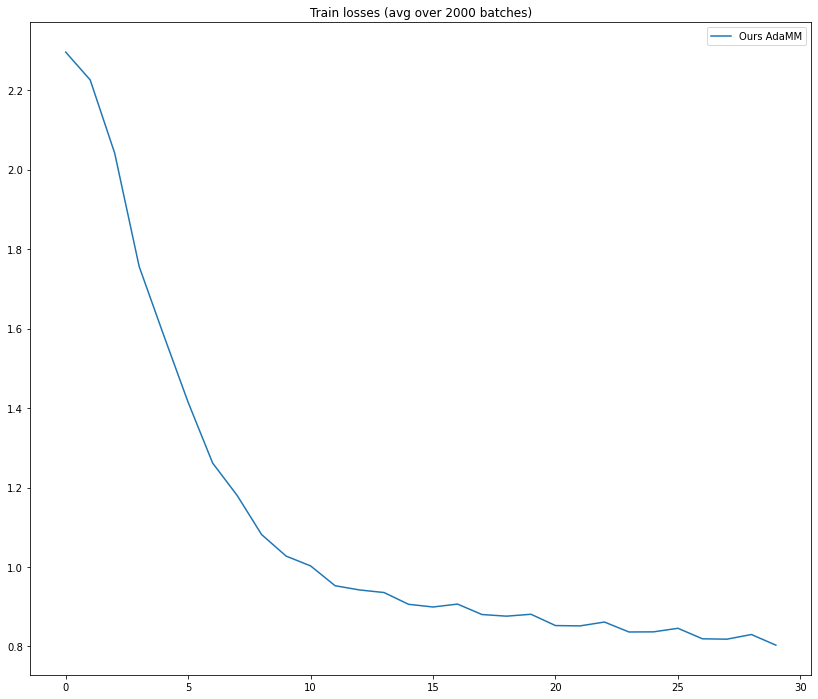

In [50]:
plt.plot(train_losses_pt, label='Ours AdaMM')
plt.title('Train losses (avg over 2000 batches)')
plt.legend()
plt.show()


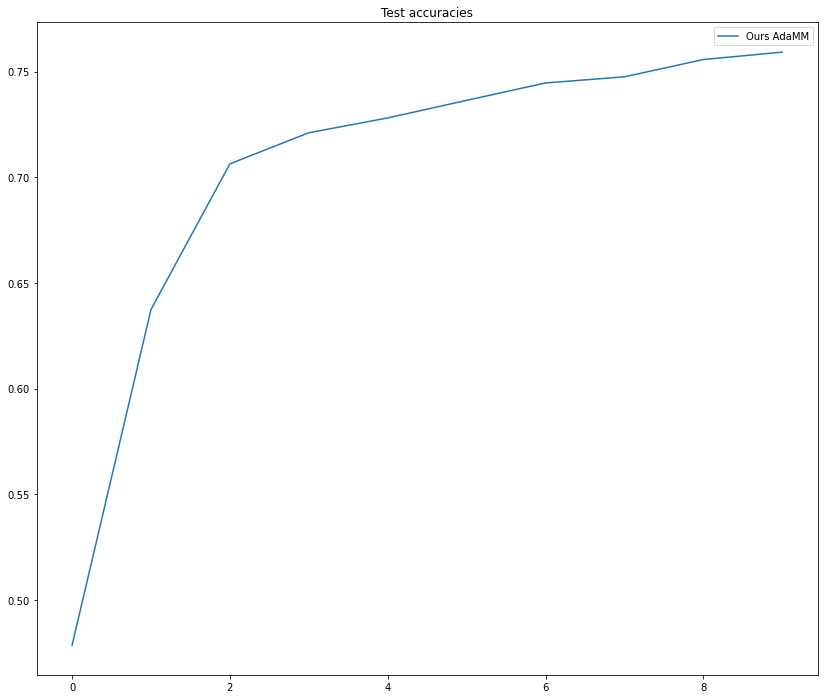

In [51]:
plt.plot(test_acc_pt, label='Ours AdaMM')
plt.title('Test accuracies')
plt.legend()
plt.show()

In [28]:
def train(model, optimizer, criterion, nb_epochs, train_loader, test_loader):
    # Heavily inspired from PyTorch tutorial
    train_losses = []
    test_accuracies = []

    running_loss = 0

    for e in range(nb_epochs):

        for i, data in enumerate(train_loader):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs)
            loss = criterion(outputs, labels)
            #print(loss)
            loss.backward()

            optimizer.step()
            #print(loss)
            #print('-----------------')

            running_loss += loss.item()

            if i % 2000 == 1999:
                train_losses.append(running_loss / 1000)
                print(f'epoch : {e + 1}/{nb_epochs} | train loss : {train_losses[-1]:.4f}')
                running_loss = 0.0

        with torch.no_grad():
            correct_preds = 0
            total_preds = 0
            for inputs, labels in test_loader:
                outputs = model(inputs)

                predictions = torch.argmax(outputs, 1)
                total_preds += labels.size(0)
                correct_preds += (predictions == labels).sum().item()

            test_accuracies.append(correct_preds / total_preds)

    return train_losses, test_accuracies

In [29]:
small_model = SmallModel()

optimizer_pt = optim.Adam(small_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, amsgrad=True)

train_losses_pt, test_acc_pt = train(small_model, optimizer_pt, criterion, nb_epochs, train_loader, test_loader)

epoch : 1/2 | train loss : 0.9642
epoch : 1/2 | train loss : 0.3972
epoch : 1/2 | train loss : 0.2683
epoch : 1/2 | train loss : 0.2589
epoch : 1/2 | train loss : 0.2081
epoch : 1/2 | train loss : 0.2267
epoch : 1/2 | train loss : 0.1921
OrderedDict([('conv1.weight', tensor([[[[ 2.3252e-01,  5.0497e-01,  5.8686e-01,  4.7517e-01,  5.6374e-01],
          [ 1.3468e-01,  3.2207e-01,  2.2452e-01,  6.0049e-02, -2.0139e-01],
          [ 3.2158e-01,  1.7144e-01, -4.9966e-01, -3.9944e-01, -6.2202e-01],
          [ 1.6832e-01, -1.8466e-01, -8.4630e-01, -7.2850e-01, -5.6543e-01],
          [ 4.2787e-01,  2.1751e-01,  1.7133e-01, -1.5446e-01,  3.6353e-02]]],


        [[[ 1.1628e-01,  4.9092e-01,  1.2266e-01,  6.7834e-04, -3.0524e-01],
          [ 2.6961e-01,  3.9760e-01,  8.7663e-02, -3.4253e-01, -1.9663e-01],
          [ 3.2530e-01,  4.4340e-01,  9.7608e-02, -5.3437e-01, -3.5293e-01],
          [ 4.3556e-01,  3.7702e-01, -2.9672e-01, -4.2699e-01,  9.7500e-02],
          [ 4.4650e-01,  2.1420e-01

In [30]:
test_acc_pt

[0.9686333333333333, 0.9751]